# Mean Maximum Discrepancy en Textos

Este notebook es una variación del `mmmd.ipynb` pero aplicando la técnica de detección de data drift sobre contenido textual. Para poder seguir el contenido de este notebook es preciso comprender conceptos como tokenización, generación de embeddings y cálculo de data drift con MMD. Todos estos contenidos están detallados en el repositorio, revisarlos en caso de ser necesario.

In [ ]:
# Para este notebook hay que tener instalado numpy, scikit-learn, matplotlib, frouros, transformer y Torch

# Imports para adquisición y gestión de datos
from kaggle.api.kaggle_api_extended import KaggleApi
import pandas as pd
import numpy as np
seed= 42
np.random.seed(seed)


# Imports para data drift
from scipy.spatial.distance import pdist
from frouros.detectors.data_drift import MMD
from frouros.utils.kernels import rbf_kernel
from functools import partial

# Imports para embeddings
from transformers import AutoModel, AutoTokenizer
import torch

# Imports para soporte gráfico
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.cm import  get_cmap
from matplotlib.lines import Line2D

## Recursos previos

En esta sección rescatamos de los notebooks de este repositorio diferentes funcionalidades como el cálculo del drift y la generación de embeddings. Estas técnicas han sido desarrolladas en detalle en sus correspondientes notebooks, por lo cual, en caso de dudas recomiendo acudir a los recursos correspondientes.

In [30]:
# Como vamos a ver la detección de data drift con varios conjuntos de datos lo hemos instanciado como un metodo.
# Recibirá un sample_a como conjunto de datos de referencia y un sample_b como el de test. Además se harán K permutaciones,
# que por defecto hemos definido como 100. 

def mmd_drift_computation(sample_a, sample_b, K = 100):

    # Para calcular el drift entre dos conjuntos de vectores con MMD vamos a seguir los siguientes pasos.


    # 1. Identificamos las muestras de referencia y test. 
    # También guardamos su tamaño porque más adelante hay que tenerlo en cuenta.
    reference_sample= sample_a
    reference_sample_size= len(sample_a)

    test_sample= sample_b
    test_sample_size= len(sample_b)


    # El método de MMD requiere de un kernel. Lo más común es utilizar RBF, como haremos en este estudio.
    # Para utilizar este kernel, hay que establecer un parámetro llamado sigma_median, que cumple una función de
    # nivel de zoom para MMD. Este valor permite a MMD ajustar la búsqueda de diferencias a una escala particular.
    # 
    # Por eso, MMD es depende en gran medida de este valor, por lo que su selección no puede ser arbitraria. 
    # La heurística más seguida en la literatura define este nivel de zoom (sigma_median) como la mediana de la
    # distancia entre todos los vectores. 
    #
    # Esto se ve aplicado de la siguiente forma:
    complete_sample= np.vstack([reference_sample, test_sample])
    pairwise_dists = pdist(complete_sample, metric="euclidean")
    sigma_median = np.median(pairwise_dists)


    # Ahora instanciamos el kernel que vamos a utilizar para MMD de la siguiente forma, ya que lo vamos a llamar en
    # repetidas ocasiones.
    custom_kernel = partial(rbf_kernel, sigma=sigma_median)


    # Con el kernel instanciado y las muestras de datos listas, podemos crear ya el detector MMD
    detector = MMD(kernel=custom_kernel)

    # Este detector lo entrenamos con los datos de referencia
    detector.fit(X=reference_sample)

    # Y ahora buscamos las diferencias con los datos de test.
    result, _ = detector.compare(X=test_sample)

    # El resultado es un número que representa la magnitud de la diferencia entre los dos conjuntos.
    # Sin embargo, esta magnitud no aporta ningún detalle sobre si los datos son diferentes o son parecidos.
    drift_magnitude = abs(result.distance)

    # Para saber si la magnitud es significativa, es decir, que prueba que los dos conjuntos de datos son diferentes, hay 
    # que llevar a cabo un test de permutación. Esto busca saber si la diferencia medida es fruto del azar o no. 
    # Para esto, hay que calcular el drift entre muestras aleatorias del conjunto entero de datos durante K permutaciones.
    # La proporción de veces que el drift observado en la permutación sea superior al medido entre los conjuntos originales
    # determinará el p-valor (la probabilidad de que sea fruto del azar la distancia). Cuanto menor sea el p-valor más significativa
    # es la diferencia.

    # La implementación se hace así:

    # Definimos la lista que guardará las veces que la magnitud observada en la permutación sea superior a la crítica (la original).
    permutation_test= []

    # Instanciamos el bucle de permutaciones
    for permutation in range(K):

        # 1. Se toma la muestra de datos completa (referencia U test) y se extraen dos conjuntos aleatorios (del mismo tamaño que los originales).
        rng = np.random.default_rng(seed=permutation) # Crear generador aleatorio
        shuffled = rng.permutation(complete_sample) # Desordenar la muestra completa
        
        # Tomar muestras de referencia y test aleatorias del mismo tamaño que las originales
        permutation_reference_sample=   shuffled[:reference_sample_size]
        permutation_test_sample=        shuffled[reference_sample_size : reference_sample_size + test_sample_size]

        # 2. Se instancia un detector MMD (con la misma configuración de kernel) y se entrena con los datos de referencia aleatorios.
        permutation_detector = MMD(kernel=custom_kernel)
        permutation_detector.fit(X=permutation_reference_sample)

        # 3. Se calcula la magnitud de drift entre el conjunto de datos de referencia aleatorio y el de test aleatorio
        result, _ = permutation_detector.compare(X=permutation_test_sample) # Calculamos el drift
        permutation_drift_magnitude = abs(result.distance) # Extraemos la magnitud del drift
        
        #4. Ahora añadimos a la lista de los resultados de la permutación 1 si el drift es superior o igual al crítico y 0 si no lo es. 
        if permutation_drift_magnitude >= drift_magnitude:
            permutation_test.append(1)
        else:
            permutation_test.append(0)
    
    # Por último calculamos el p-valor como la propoción de veces que el drift observado es superior al drift crítico.
    p_value = (1 + sum(permutation_test)) / (K + 1) # Sumamos 1 para evitar tener p-values de 0

    return drift_magnitude, p_value

In [31]:
# Para minimizar el ruido en el conjunto de datos hemos instanciado como método la generación de embeddings.
# A través de este método podremos pasarle una lista de textos y un modelo del lenguaje para que nos devuelva
# los embeddings.

def generate_embeddings(texts, pretrained_model, batch_size=128):
    # Antes de introducir cualquier texto a un modelo hay que tokenizarlo, es decir, convertirlo en carácteres que el modelo si entiende.
    # Para esto, cargamos el tokenizador y lo usamos tal cual se explica en el tutorial de tokenización.
    tokenizer = AutoTokenizer.from_pretrained(pretrained_model)

    # También cargamos el modelo con el que generaremos los embeddings en forma de solo inferencia
    model= AutoModel.from_pretrained(pretrained_model)
    encoder= model
    if model.config.is_encoder_decoder:
        encoder= model.encoder

    encoder.eval()

    # Asignamos el modelo al dispositivo correspondinete
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    encoder.to(device)

    # Si el tokenizer trae un max_length absurdo lo normalizamos a algo más manejable
    tok_max = getattr(tokenizer, "model_max_length", None)
    if isinstance(tok_max, int) and 1 < tok_max < 100000:
        max_length = min(max_length, tok_max)

    # Ahora, para mejorar el rendimiento, vamos a procesar los textos por batches
    all_embeddings= []
    for start in range(0, len(texts), batch_size):
        end = start + batch_size
        batched_text = texts[start:end]

        # Tokenizamos el texto que vamos a dar al modelo
        tokenized_texts = tokenizer(batched_text, 
                                    max_length= 1024, # Ponemos un límite al tamaño de tokens porque el modelo es capaz de trabajar con entradas grandes. 
                                    padding=True, truncation=True, 
                                    return_tensors='pt').to(device)

        # Ahora pasamos todo lo que nos devuelve el tokenizador por el modelo.
        # Además, realizamos esto dentro del entorno no_grad() para que vaya más rápida la inferencia.
        with torch.no_grad():
            outputs= encoder(**tokenized_texts) # La salida del modelo
            mask = tokenized_texts["attention_mask"].unsqueeze(-1) # Para evitar usar los embeddings de los padding
            mean_pooling_embedding = (outputs.last_hidden_state * mask).sum(1) / mask.sum(1).clamp(min=1)
        
        all_embeddings.append(mean_pooling_embedding.cpu())

    return torch.cat(all_embeddings, dim=0) 

## Carga de datos

El primer paso es obtener el conjunto de datos con el que vamos a trabajar. Este conjunto lo vamos a descargar a través de la api de Kaggle, aunque si se prefiere se puede descargar a mano y continuar el proceso a partir de la carga del recurso.

In [32]:
# Para descargar los datos por la API de kaggle primero tenemos que autenticarnos en ella
api = KaggleApi()
api.authenticate()

# Después hay que seleccionar el conjunto d edatos que se desea cargar
dataset_name= "rmisra/news-category-dataset"

# Por último lo descargamos en la carpeta data que se creará automaticamente
api.dataset_download_files(dataset_name, path="data", unzip=True)

Dataset URL: https://www.kaggle.com/datasets/rmisra/news-category-dataset


In [33]:
# Ahora cargamos el recurso
df= pd.read_json("data/News_Category_Dataset_v3.json", lines=True)

# Convertimos las fechas a datetime y ordenamos los artículos
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')

# Dado que el tamaño del dataset es muy grande, vamos a tomar un subconjunto centrado en noticias de política que contengan una descripción breve.
# Después de analizar el contenido de las noticias de política y como el conjunto de datos proviene de un medio estadounidense, nos hemos dado cuenta
# de que estas noticias están centradas en política nacional estadounidense. 
# Esto es importante para más adelante analizar los resultados del estudio del data drift.
df= df[
    (df["category"]=='POLITICS') &
    (df["short_description"]!='') 
    ]
# Las demás categorías sobre las que se puede replicar este trabajo son:
# 'U.S. NEWS', 'COMEDY', 'PARENTING', 'WORLD NEWS', 'CULTURE & ARTS',
# 'TECH', 'SPORTS', 'ENTERTAINMENT', 'POLITICS', 'WEIRD NEWS',
# 'ENVIRONMENT', 'EDUCATION', 'CRIME', 'SCIENCE', 'WELLNESS',
# 'BUSINESS', 'STYLE & BEAUTY', 'FOOD & DRINK', 'MEDIA',
# 'QUEER VOICES', 'HOME & LIVING', 'WOMEN', 'BLACK VOICES', 'TRAVEL',
# 'MONEY', 'RELIGION', 'LATINO VOICES', 'IMPACT', 'WEDDINGS',
# 'COLLEGE', 'PARENTS', 'ARTS & CULTURE', 'STYLE', 'GREEN', 'TASTE',
# 'HEALTHY LIVING', 'THE WORLDPOST', 'GOOD NEWS', 'WORLDPOST',
# 'FIFTY', 'ARTS', 'DIVORCE'


# Como el conjunto de datos sigue siendo muy grande para el propósito de este dataset vamos a obtener una muestra de 100 noticias por año como máximo.
df['year'] = df['date'].dt.year
groups = df.groupby("year", group_keys=False)
df = pd.concat(
    [g.sample(n=min(100, len(g)), random_state=seed) for _, g in groups],
    ignore_index=True
)

df= df.reset_index(drop=True)

print(f"El dataset resultante tiene {df.shape[0]} instancias.")


El dataset resultante tiene 900 instancias.


## Generación de embeddings

Ahora vamos a generar los embeddings para las descripciones de las noticias. Es recomendable hacer este paso por separado ya que los embeddings solo hace falta generarlos una vez.

In [34]:
# La particularidad que tiene calcular el data drift sobre contenido textual es que este ha de ser vectorizado.
# Existen dos principales estrategias, convertirlo a embeddings o utilizar modelos de feature_extraction para recoger atributos.
# En este estudio seguiremos la primera estrategia, que a su vez es la más común. Trabajaremos con la descripción de la noticia, 
# que aporta más detalle que el titular y favorecerá a la calidad del embedding.


# Primero generamos los embeddings para todas las descripciones con el siguiente modelo:
pretrained_model= "google/mt5-base"

embeddings= generate_embeddings(df["short_description"].to_list(), pretrained_model)
# Como los embeddings los vamos a usar con técnicas que no funcionan en gpu los movemos a la cpu y a formato lista
embeddings= embeddings.cpu().numpy()

/home/ibai/anaconda3/envs/notebooks/lib/python3.13/site-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


## Calculando el Drift

Una vez generados los embeddings vamos a hacer las particiones para medir los cambios entre las noticias. En este caso vamos a analizar como han cambiado las noticias a lo largo de los años. Sin embargo, en dominios con particularidades como el político se podrían hacer estudios sobre como cambian las noticias de un periodo electoral con las del siguiente; cómo cambian las noticias publicadas durante un gobierno de una ideología comparado con las publicadas durante un mandato de otra ideología, etc.

In [35]:
# Identificamos los años para realizar las agrupaciones
unique_years= df["year"].unique().tolist()

# Instnaciamos un diccionario que guradara toda la información sobre el drift calculado
drift= {}
for reference_year in unique_years:
    # Definimos los datos de referencia
    reference_data= df[df["year"]==reference_year].index
    drift[reference_year]= {}
    print(f"--- {reference_year} ---")

    for test_year in unique_years:
        # Nunca mediremos la diferencia de un conjunto consigo mismo porque siempre será magnitud 0 y p_valor 1. 
        # Por eso omitiremos este caso y lo añadimos, ahorrando coste computacional.
        if test_year == reference_year:
            drift[reference_year][test_year]= {"magnitude": 0, "p_value": 1}
            continue
        
        # Instanciamos los datos de test
        test_data= df[df["year"]==test_year].index

        # Calculamos y guardamos la magnitud del drift y su significancia
        magnitude, p_value= mmd_drift_computation(embeddings[reference_data], embeddings[test_data])
        drift[reference_year][test_year]= {"magnitude": magnitude, "p_value": p_value}

--- 2014 ---
--- 2015 ---
--- 2016 ---
--- 2017 ---
--- 2018 ---
--- 2019 ---
--- 2020 ---
--- 2021 ---
--- 2022 ---


## Representación Gráfica

/home/ibai/anaconda3/envs/notebooks/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/tmp/ipykernel_13991/1489779826.py:56: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap(cmap_name)


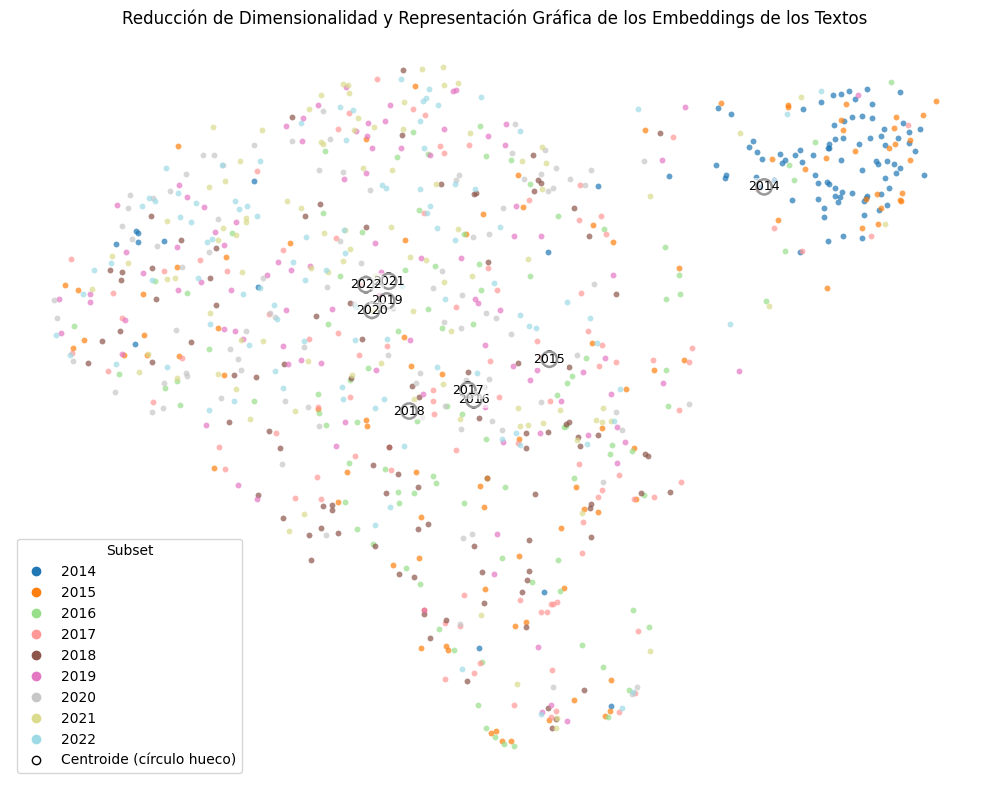

In [36]:
# Opcionalmente y con objeto de analizar el contenido de los textos y como cambian con el tiempo, podemos reducir la dimensionalidad de estos a dos dimensiones 
# y mostrarlo gráficamente. Aunque el gráfico no es representativo puesto que la representación de dimensionalidad reducida no tiene porque ser fiel a lo original,
# nos puede ayudar a entender la composición del dataset y guiarnos en nuestros experimentos. 
# En este caso vamos a usar UMAP, para lo que es necesario tener instalado el paquete umap. Esto es totalmente opcional y sirve como soporte al estudio del data drift.

import umap

def umap_por_subset(
    embeddings_por_subset,   # List[np.ndarray], cada uno (n_i, d)
    subset_names,            # List[str], len == len(embeddings_por_subset)
    n_neighbors=15,
    min_dist=0.1,
    metric="cosine",
    random_state=42,
    figsize=(10,8),
    alpha=0.7,
    cmap_name="tab20",       # colormap categórico
    show_centroids=True,
    centroid_size=120,
    centroid_edgecolor="k",
    connect_centroids_order=None,  # opcional: lista con el orden para unir centroides
    title="Reducción de Dimensionalidad y Representación Gráfica de los Embeddings de los Textos",
    hide_xy_ticks=True       # <- nuevo: oculta escala de ejes
):
    # --- Validaciones ---
    if len(embeddings_por_subset) != len(subset_names):
        raise ValueError("len(embeddings_por_subset) debe ser igual a len(subset_names).")
    if any(arr.ndim != 2 for arr in embeddings_por_subset):
        raise ValueError("Cada elemento de embeddings_por_subset debe ser 2D: (n_i, d).")
    dims = [arr.shape[1] for arr in embeddings_por_subset if arr.size > 0]
    if len(set(dims)) > 1:
        raise ValueError("Todas las matrices deben tener la misma dimensionalidad de embedding.")

    # --- Aplanar X y crear etiquetas por muestra ---
    X = np.concatenate(embeddings_por_subset, axis=0) if embeddings_por_subset else np.empty((0,0))
    subset_labels = []
    for arr, name in zip(embeddings_por_subset, subset_names):
        subset_labels.extend([name] * arr.shape[0])
    subset_labels = np.array(subset_labels)

    if X.shape[0] != subset_labels.shape[0]:
        raise RuntimeError("El nº de filas de X no coincide con el nº de etiquetas expandidas.")

    # --- UMAP único ---
    reducer = umap.UMAP(
        n_components=2,
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        metric=metric,
        random_state=random_state
    )
    X_2d = reducer.fit_transform(X)

    # --- Asignar colores por subset (discretos) ---
    uniq_subsets = np.unique(subset_labels)
    cmap = get_cmap(cmap_name)
    n_colors = max(len(uniq_subsets), 1)
    colors = {s: cmap(i / max(n_colors-1, 1)) for i, s in enumerate(uniq_subsets)}

    # --- Plot ---
    fig, ax = plt.subplots(figsize=figsize)
    for s in uniq_subsets:
        idx = np.where(subset_labels == s)[0]
        ax.scatter(
            X_2d[idx, 0], X_2d[idx, 1],
            c=[colors[s]],
            s=18,
            alpha=alpha,
            linewidths=0,
            label=s
        )

    # --- Centroides ---
    centroids = {}
    if show_centroids:
        for s in uniq_subsets:
            idx = np.where(subset_labels == s)[0]
            if len(idx) == 0:
                continue
            cxy = X_2d[idx].mean(axis=0)
            centroids[s] = cxy
            ax.scatter(
                cxy[0], cxy[1],
                s=centroid_size,
                facecolors="none",
                edgecolors=centroid_edgecolor,
                linewidths=1.8
            )
            ax.text(cxy[0], cxy[1], s, fontsize=9, ha="center", va="center",
                    bbox=dict(facecolor="white", alpha=0.6, edgecolor="none", pad=1.5))

    # --- Conectar centroides en orden (opcional) ---
    if connect_centroids_order:
        missing = [s for s in connect_centroids_order if s not in centroids]
        if missing:
            raise ValueError(f"Faltan centroides para subsets en 'connect_centroids_order': {missing}")
        path = np.array([centroids[s] for s in connect_centroids_order])
        ax.plot(path[:,0], path[:,1], linewidth=2.2, alpha=0.9, linestyle="-", color="k")

    # --- Leyenda: subsets + centroide ---
    handles = [Line2D([0],[0], marker='o', linestyle='', color=colors[s], label=s) for s in uniq_subsets]
    if show_centroids:
        centroid_handle = Line2D([0],[0],
                                 marker='o', linestyle='',
                                 markerfacecolor='none',
                                 markeredgecolor=centroid_edgecolor,
                                 label='Centroide (círculo hueco)')
        handles.append(centroid_handle)
    ax.legend(handles=handles, title="Subset", frameon=True, loc="best")

    # --- Títulos ---
    ax.set_title(title)
    # --- Ocultar escala de ejes (ticks/números) ---
    ax.set_xticks([])
    ax.set_yticks([])
    # opcional: ocultar marcos para un look limpio
    for spine in ax.spines.values():
        spine.set_visible(False)

    fig.tight_layout()
    plt.show()

    return X_2d, subset_labels

X_2d, years_labels = umap_por_subset([embeddings[df[df["year"]==_year].index] for _year in unique_years], unique_years, n_neighbors=30, min_dist=0.05)


In [37]:
# En cuanto al data drift, para facilitar el estudio de los resultados en este tipo de entornos,
# lo más intuitivo es un mapa de calor.
# En este caso, vamos a generar un mapa de calor que represente la matriz de magnitudes de drift. Además,
# para saber si el drift es significativo o no representaremos las magnitudes NO significativas ensombrecidas.
# Para ello dibujaremos unas líneas negras diagonales en esas casillas que no cumplan el valor del umbral de drift.

def generate_drift_hetamap(drift: dict, TRESHOLD: float = 0.05, title="Drift magnitude"):
    """
    Genera un heatmap de magnitudes (azul=min, rojo=max) a partir de un dict anidado:
      drift[row_key][col_key] = {'magnitude': float, 'p_value': float}
    Además, superpone líneas diagonales negras en las celdas con p_value < TRESHOLD.

    Parámetros
    ----------
    drift : dict
        Diccionario anidado {fila: {columna: {'magnitude': float, 'p_value': float}}}
    TRESHOLD : float, opcional (por defecto 0.05)
        Umbral de significación para sombrear con hatch las celdas.

    Retorna
    -------
    fig, ax : matplotlib Figure y Axes
    """
    # 1) Orden de filas y columnas (usa orden natural si son números; si prefieres el de inserción, quita 'sorted')
    rows = sorted(drift.keys())
    # Asegurar columnas a partir de todas las keys internas (por si alguna fila tiene columnas distintas)
    all_cols = set()
    for r in drift:
        all_cols.update(drift[r].keys())
    cols = sorted(all_cols)

    # 2) Construir matrices de magnitudes y p-values (relleno con NaN si falta alguna celda)
    M = np.full((len(rows), len(cols)), np.nan, dtype=float)
    P = np.full_like(M, np.nan)

    for i, r in enumerate(rows):
        for j, c in enumerate(cols):
            cell = drift.get(r, {}).get(c, None)
            if cell is not None:
                M[i, j] = float(cell['magnitude'])
                P[i, j] = float(cell['p_value'])

    # 3) Rango de color (min->max) ignorando NaNs
    vmin = np.nanmin(M)
    vmax = np.nanmax(M)
    if not np.isfinite(vmin) or not np.isfinite(vmax):
        raise ValueError("La matriz de magnitudes está vacía o solo tiene NaNs.")

    # 4) Plot
    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(M, cmap='bwr', vmin=vmin, vmax=vmax, aspect='auto')

    # 5) Ticks y etiquetas
    ax.set_xticks(np.arange(len(cols)))
    ax.set_yticks(np.arange(len(rows)))
    ax.set_xticklabels(cols)
    ax.set_yticklabels(rows)
    ax.set_xlabel("Año de publicación de las noticias")
    ax.set_ylabel("Año de publicación de las noticias")
    ax.set_title(title)

    # 6) Cuadrícula ligera
    ax.set_xticks(np.arange(-0.5, len(cols), 1), minor=True)
    ax.set_yticks(np.arange(-0.5, len(rows), 1), minor=True)
    ax.grid(which="minor", color="white", linestyle='-', linewidth=1, alpha=0.6)
    ax.tick_params(which="minor", bottom=False, left=False)

    # 7) Sombreado (hatch) para p_value < TRESHOLD
    for i in range(len(rows)):
        for j in range(len(cols)):
            if np.isfinite(P[i, j]) and P[i, j] >= TRESHOLD:
                # Cada celda va de (j-0.5, i-0.5) a (j+0.5, i+0.5) en coordenadas de imshow
                rect = Rectangle((j-0.5, i-0.5), 1, 1,
                                 fill=False, hatch='///', edgecolor='0.0', linewidth=0.0)
                ax.add_patch(rect)

    # 8) Barra de color
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label("Magnitude")

    fig.tight_layout()
    return fig, ax

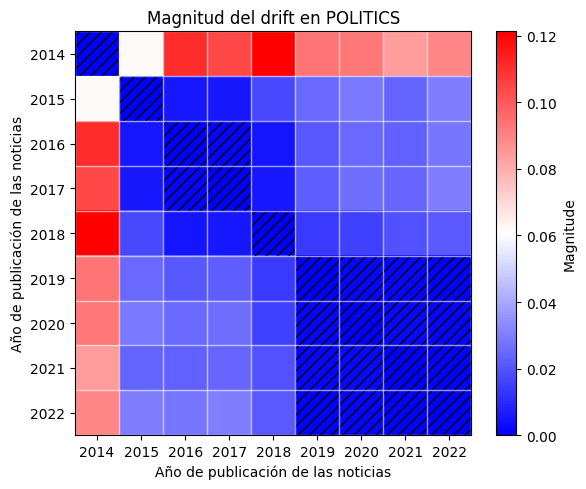

In [38]:
# El resultado puede ver de la siguiente forma
fig, ax = generate_drift_hetamap(drift, TRESHOLD=0.05, title="Magnitud del drift en POLITICS")
plt.show()

¿Cómo podemos interpretar este gráfico?

Vamos a buscar: cuando han ocurrido las elecciones estadounidenses; cuales han sido los periodos de gobierno; quién ha gobernado en cada periodo; y si ha ocurrido algo de alta relevancia que pueda afectar al dominio político durante los años analizados.

Elecciones: 
- 8 de noviembre de 2016
- 3 de noviembre de 2020 

Periodos electorales:
- Barack Obama (Demócrata) --> 20 enero 2013 - 20 enero 2017
- Donald Trump (Republicano) --> 20 enero 2017 - 20 enero 2021
- Joe Biden (Demócrata) --> 20 enero 2021 - 20 enero 2025

Sucesos de relevancia en el discurso político:
- Pandemia del COVID-19 --> 2020


Con esta información, hay que analizar los cambios detectados y medidos para tratar de expresar lo que ha ocurrido. Un estudio como este solo es válido como premisa para un estudio cualitativo en mayor profundidad. No podemos deducir el cambio en los textos a partir de esta información porque puede que no sea real. Sin embargo, nos permite saber en que cosas profundizar con mayor detalle y en cuales con menos.